ผู้จัดทำต้องการทดสอบการ select feature ของตนเองเทียบกับการ select feature ของตัว PCA โดยผ่านตัว model K_mean
เกิดสมมติฐานในการทดลองของ Homework 3 เพื่อทำการ cluster ข้อมูลออกมา

1.ตัว select feature PCA สามารถเลือก feature ที่ดีที่สุดออกมาและทำการ Train ด้วย model K_mean ได้ผลลัพธ์ของ cluster ที่อธิบายข้อมูลได้ดีที่สุด

2.เราสามารถ select feature ที่มีความสำคัญได้จากการเทียบกับตัว target ที่ถูกอธิบายไว้ใน dataset ของ credit_card_chun โดยพิจารณาจากทางผู้จัดทำ และทำการ Train ด้วย model K_mean ได้ผลลัพธ์ของ cluster ที่อธิบายข้อมูลได้ดีที่สุด

3.ปรับตัว cluster ให้เหมือนกันทั้ง assumption 1 และ assumption 2 เพื่อทำการดูข้อมูลที่ถูก cluster ออกมาแล้วหา model ที่ Preprocess ดีที่สุด (ดูเรื่อง Centroid ของข้อมูล,ดูเรื่องการซ้อนทับกันของข้อมูล, การกระจายตัวรอบจุด Centroid ของข้อมูล เป็นต้น)

### **1. Data Exploration**

In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import floor


In [223]:
df = pd.read_csv("credit_card_churn.csv",header = 0) 
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [224]:
df = df.drop(['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1'],axis=1) 

In [225]:
df.shape

(10127, 21)

In [226]:
df.dtypes

CLIENTNUM                     int64
Attrition_Flag               object
Customer_Age                  int64
Gender                       object
Dependent_count               int64
Education_Level              object
Marital_Status               object
Income_Category              object
Card_Category                object
Months_on_book                int64
Total_Relationship_Count      int64
Months_Inactive_12_mon        int64
Contacts_Count_12_mon         int64
Credit_Limit                float64
Total_Revolving_Bal           int64
Avg_Open_To_Buy             float64
Total_Amt_Chng_Q4_Q1        float64
Total_Trans_Amt               int64
Total_Trans_Ct                int64
Total_Ct_Chng_Q4_Q1         float64
Avg_Utilization_Ratio       float64
dtype: object

ทำการแยก feature ตามชนิดข้อมูลโดย feature ที่เป็นตัวเลขจะเก็บไว้ในตัวแปร Num_df และ feature ที่เป็นตัวอักษรจะเก็บไว้ในตัวแปร Cat_df

In [227]:
Cat_df = df.select_dtypes(include=['object'])
Num_df = df.select_dtypes(exclude=['object'])

print("caterical is " + str(Cat_df.shape))
print("Numurical is " + str(Num_df.shape))

caterical is (10127, 6)
Numurical is (10127, 15)


จากการสำรวจพบว่า feature ที่เป็นตัวเลขมีทั้งหมด 15 feature และมี feature ที่เป็นตัวอักษรมีทั้งหมด 6 feature .

**โดยที่**
### Numurical 
1. CLIENTNUM                   คือ  หมายเลขประจำตัวของเจ้าของบัญชี
2. Customer_Age                คือ  อายุของเจ้าของบัญชี
3. Dependent_count             คือ  เจ้าของบัญชีมีผู้ที่อยู่ในอุปการะกี่คน 
4. Months_on_book              คือ  เจ้าของบัญชีเปิดบัญชีมาแล้วกี่เดือน
5. Total_Relationship_Count    คือ  จำนวนสินค้าที่เจ้าของบัญชีครอบครอง
6. Months_Inactive_12_mon      คือ  จำนวนเดือนที่ไม่ได้ใช้งานในช่วง 12 เดือนที่ผ่านมา
7. Contacts_Count_12_mon       คือ  จำนวนที่มีการติดต่อกับธนาคาร
8. Credit_Limit                คือ  วงเงินในบัตรเครดิต
9. Total_Revolving_Bal         คือ  จำนวนเงินที่เกินวงเงินของบัตรเครดิต
10. Avg_Open_To_Buy            คือ  Credit_Limit - Total_Revolving_Bal
11. Total_Amt_Chng_Q4_Q1       คือ  จำนวนเงินที่ ฝาก-ถอน ใน 1 ไตรมาส
12. Total_Trans_Amt            คือ  จำนวนเงินที่ถูกหักจากบัญชีผ่านบัตรเครดิต
13. Total_Trans_Ct             คือ  จำนวนการทำธุรกรรมในช่วง 12 เดือนที่ผ่านมา
14. Total_Ct_Chng_Q4_Q1        คือ  การเปลี่ยนเปลงจำนวนธุรกรรมในช่วงไตรมาสที่ผ่านมา
15. Avg_Utilization_Ratio      คือ  อัตราเฉลี่ยการใช้บัตร  Total_Revolving_Bal / Credit_Limit

### caterical 
1. Attrition_Flag              คือ  สถานะของเจ้าของบัญชี ได้แก่ ปิดบัญชีแล้ว(Attrited ) และ ยังใช้งานอยู่(Existing )
2. Gender                      คือ  เพศของเจ้าของบัญชี
3. Education_Level             คือ  คุณสมบัติทางการศึกษาของเจ้าของบัญชี
4. Marital_Status              คือ  สถานสมรสของเจ้าของบัญชี
5. Income_Category             คือ  รายได้ประจำปีของเจ้าของบัญชี
6. Card_Category               คือ  ประเภทของบัตรเครดิต


In [228]:
df.isnull().sum()

CLIENTNUM                   0
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

In [229]:
df['Income_Category'].value_counts() 

Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
Unknown           1112
$120K +            727
Name: Income_Category, dtype: int64

In [230]:
df = df.replace("Unknown",np.nan)
df = df.dropna()
df.shape


(7081, 21)

In [231]:
df['Income_Category'].value_counts() 

Less than $40K    2792
$40K - $60K       1412
$80K - $120K      1202
$60K - $80K       1103
$120K +            572
Name: Income_Category, dtype: int64

In [232]:
# sns.pairplot(df, hue="Attrition_Flag")

In [233]:
df.drop(['CLIENTNUM'],axis=1,inplace=True)

In [234]:
# df_not_y = df.copy()
# df_not_y = df_not_y.drop(['Attrition_Flag'],axis=1)
df_onehot = pd.get_dummies(df)

## ทำการ Train Model K_mean และเลือก select feature โดยผ่านตัว PCA

In [235]:
df_onehot.head()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,...,Marital_Status_Single,Income_Category_$120K +,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,45,3,39,5,1,3,12691.0,777,11914.0,1.335,...,0,0,0,1,0,0,1,0,0,0
1,49,5,44,6,1,2,8256.0,864,7392.0,1.541,...,1,0,0,0,0,1,1,0,0,0
2,51,3,36,4,1,0,3418.0,0,3418.0,2.594,...,0,0,0,0,1,0,1,0,0,0
4,40,3,21,5,1,0,4716.0,0,4716.0,2.175,...,0,0,0,1,0,0,1,0,0,0
5,44,2,36,3,1,2,4010.0,1247,2763.0,1.376,...,0,0,1,0,0,0,1,0,0,0


In [236]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [237]:
scalar = StandardScaler()
x_transform = scalar.fit_transform(df_onehot)
X = pd.DataFrame(x_transform,columns=df_onehot.columns)
X

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,...,Marital_Status_Single,Income_Category_$120K +,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,-0.167610,0.512710,0.377234,0.764487,-1.349309,0.493777,0.460058,-0.480760,0.502567,2.574433,...,-0.844561,-0.296443,-0.499073,2.328039,-0.452169,-0.806826,0.270562,-0.107571,-0.039445,-0.241755
1,0.329862,2.061228,1.002074,1.412015,-1.349309,-0.411332,-0.025947,-0.373652,0.007308,3.497689,...,1.184047,-0.296443,-0.499073,-0.429546,-0.452169,1.239425,0.270562,-0.107571,-0.039445,-0.241755
2,0.578598,0.512710,0.002330,0.116959,-1.349309,-2.221550,-0.556114,-1.437353,-0.427933,8.217051,...,-0.844561,-0.296443,-0.499073,-0.429546,2.211564,-0.806826,0.270562,-0.107571,-0.039445,-0.241755
3,-0.789449,0.512710,-1.872192,0.764487,-1.349309,-2.221550,-0.413874,-1.437353,-0.285773,6.339166,...,-0.844561,-0.296443,-0.499073,2.328039,-0.452169,-0.806826,0.270562,-0.107571,-0.039445,-0.241755
4,-0.291978,-0.261549,0.002330,-0.530569,-1.349309,-0.411332,-0.491240,0.097873,-0.499670,2.758188,...,-0.844561,-0.296443,2.003715,-0.429546,-0.452169,-0.806826,0.270562,-0.107571,-0.039445,-0.241755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7076,0.951702,-1.035808,-0.247607,0.764487,-0.344317,-2.221550,0.596928,1.159112,0.493477,-0.450798,...,1.184047,-0.296443,-0.499073,2.328039,-0.452169,-0.806826,0.270562,-0.107571,-0.039445,-0.241755
7077,1.200438,-1.035808,1.751883,0.116959,-1.349309,1.398886,-0.526526,-0.691285,-0.464732,-0.854163,...,1.184047,-0.296443,-0.499073,-0.429546,-0.452169,1.239425,0.270562,-0.107571,-0.039445,-0.241755
7078,0.454230,-0.261549,0.502202,-0.530569,-0.344317,0.493777,-0.492007,0.841479,-0.566588,-0.258080,...,1.184047,-0.296443,2.003715,-0.429546,-0.452169,-0.806826,0.270562,-0.107571,-0.039445,-0.241755
7079,-0.291978,-1.035808,0.002330,0.764487,0.660674,1.398886,-0.337932,-1.437353,-0.209874,0.261812,...,-0.844561,-0.296443,-0.499073,-0.429546,-0.452169,1.239425,0.270562,-0.107571,-0.039445,-0.241755


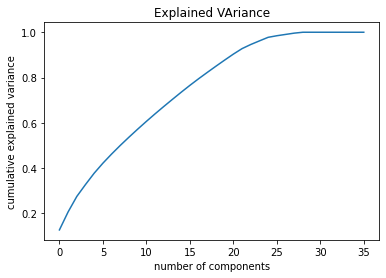

In [238]:
from sklearn.decomposition import PCA
pca = PCA()
principalComponents = pca.fit_transform(X)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.title("Explained VAriance")
plt.show()

In [239]:
pca = PCA(n_components=23)
new_data = pca.fit_transform(X)
print(new_data)

[[ 1.47274304e+00 -6.19836487e-01 -3.10296773e+00 ...  1.60945085e+00
   9.50709432e-01 -1.97099171e-01]
 [-1.45018187e+00 -3.28225432e+00 -1.14415560e+00 ...  2.24125662e+00
   2.00137631e+00 -6.83599264e-01]
 [ 9.32012687e-01 -1.91103195e+00 -3.90557442e+00 ...  2.11373987e+00
  -1.17920806e+00  4.20236543e-01]
 ...
 [ 3.23875414e-01 -2.60375607e+00  3.31143323e-01 ...  1.08720822e-03
   9.49894445e-01  1.12191000e+00]
 [-1.31151665e+00  2.46879746e+00  1.75780333e+00 ... -4.44563133e-01
   5.98447070e-01  1.52734791e+00]
 [ 5.97710711e-01  1.04762345e+00  4.34176039e+00 ...  1.96988374e-01
   6.36454684e-01  2.44619909e+00]]


In [240]:
principal_x = pd.DataFrame(new_data,columns=['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11','PC12','PC13','PC14','PC15','PC16','PC17','PC18','PC19','PC20','PC21','PC22','PC23'])
principal_x

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23
0,1.472743,-0.619836,-3.102968,-0.075041,0.975035,0.968746,1.126299,1.649076,2.520154,2.843923,...,0.267625,1.227018,-0.096131,0.210950,-0.722744,-0.283807,-0.342506,1.609451,0.950709,-0.197099
1,-1.450182,-3.282254,-1.144156,-0.149847,0.089653,4.159570,-2.139806,4.603574,5.079306,1.513072,...,1.531594,3.555942,0.510734,0.072204,-2.927925,-1.439229,-0.120735,2.241257,2.001376,-0.683599
2,0.932013,-1.911032,-3.905574,-0.365675,1.732755,1.726713,-2.154872,4.131543,5.362755,1.086844,...,0.366384,2.878704,1.081081,0.569486,-1.795461,-0.922655,-0.325801,2.113740,-1.179208,0.420237
3,0.799195,-2.136398,-3.964562,1.731789,2.599825,1.885366,0.383401,4.192449,5.565758,1.247275,...,0.916233,1.799702,0.033711,0.408505,-2.091021,-1.383043,-0.305430,1.599067,-1.367967,0.203381
4,-0.115588,-0.035327,-2.583421,-0.143826,1.204859,0.478563,-1.344516,-1.187125,2.169541,-0.180029,...,0.498552,0.692839,-0.136500,0.400072,-0.180336,-0.004374,-0.529690,1.283598,-0.900027,-0.550542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7076,1.896355,-2.798735,-0.096008,0.931954,-2.506164,-1.670644,1.107701,-0.398640,-0.451578,2.328396,...,-0.346560,-0.174551,0.003721,-0.154274,0.091120,-0.422749,-0.107353,-0.130632,-1.355091,2.277333
7077,-1.326333,-1.872475,2.432823,-0.700857,-2.503808,-1.450526,-1.817102,0.662662,0.226569,0.530435,...,-0.539060,-0.544831,-0.112548,-0.079860,1.553518,1.151673,-0.977032,1.007952,1.468803,1.162490
7078,0.323875,-2.603756,0.331143,0.942347,-2.165844,-1.902877,-1.492434,-2.367319,0.368817,-0.428250,...,-0.148289,0.013696,-0.312877,0.093319,0.840070,0.280112,-0.480580,0.001087,0.949894,1.121910
7079,-1.311517,2.468797,1.757803,-0.259343,1.151623,-1.472092,1.293274,1.238150,0.590069,1.883057,...,-0.714831,0.649910,-0.055223,-0.166550,1.397638,0.646917,-0.330483,-0.444563,0.598447,1.527348


In [241]:
principal_x.columns

Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
       'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19',
       'PC20', 'PC21', 'PC22', 'PC23'],
      dtype='object')

In [242]:
from sklearn.cluster import KMeans
from sklearn import metrics


In [243]:
Num_K = [i+2 for i in range(9)]
silhouette_coef = []

for k in Num_K:
  kmeans = KMeans(n_clusters=k, random_state=1,)
  model = kmeans.fit(principal_x)
  labels = model.labels_
  silhouette_coef.append(metrics.silhouette_score(principal_x, labels, metric='euclidean'))
silhouette_coef


[0.10979256340805783,
 0.11381597163764871,
 0.1179713377069677,
 0.10024233218504194,
 0.10880556815400724,
 0.12139131127931821,
 0.12543795588411746,
 0.10294652294693545,
 0.12120829803696294]

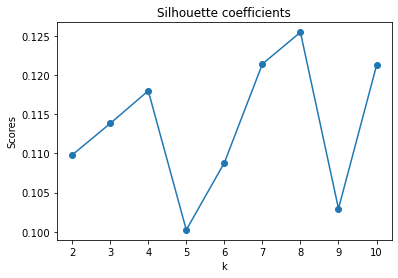

In [244]:
plt.scatter(Num_K, silhouette_coef)
plt.plot(Num_K, silhouette_coef)
plt.title('Silhouette coefficients')
plt.ylabel('Scores')
plt.xlabel('k')
plt.show()


In [245]:
Num_K = [i+1 for i in range(10)]
WCSS = []

for k in Num_K:
  kmeans = KMeans(n_clusters=k, random_state=1,)
  model = kmeans.fit(principal_x)
  WCSS.append(model.inertia_)
WCSS

[241103.31278390493,
 215957.98876941265,
 200452.95154946583,
 187825.28528568443,
 180691.91266021092,
 173751.66876896727,
 167306.82549481624,
 160156.43711909855,
 156103.90323561197,
 151251.58693182736]

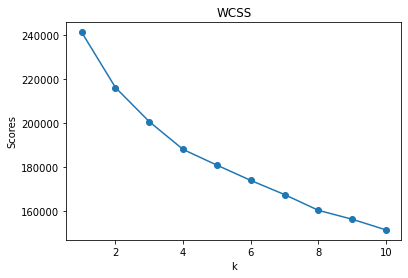

In [246]:
plt.scatter(Num_K,WCSS )
plt.plot(Num_K,WCSS )
plt.title('WCSS')
plt.ylabel('Scores')
plt.xlabel('k')
plt.show()

In [247]:
# kmeans = KMeans(n_clusters=4, random_state=1,)
# model = kmeans.fit(principal_x)
# label = model.labels_
# label

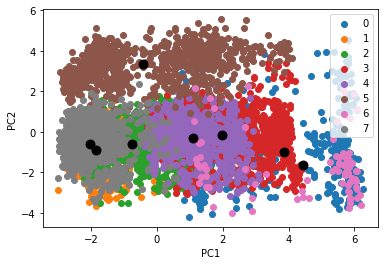

In [248]:
#Initialize the class object
kmeans = KMeans(n_clusters= 8)
 
#predict the labels of clusters.
label = kmeans.fit_predict(new_data)
 
#Getting unique labels
centroids = kmeans.cluster_centers_
u_labels = np.unique(label)
 
#plotting the results:
for i in u_labels:
    plt.scatter(new_data[label == i , 0] , new_data[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

Implement K-Means with Elbow Method โดยการหา defining error โดยจำนวน cluster ที่มากขึ้นทำให้ค่า error ที่ return ออกมาในตารางมีค่าลดลง และจากใน ตารางของเราเลือกใช้ cluster=8 เพราะเป็นจุดที่เป็น tiny difference กับ big difference มาบรรจบกัน และสาเหตุที่เรา plot ให้ run แค่ 10 รอบเนื่องจากกันการ overfit ที่เกิดจาการสร้าง centroid ของตัว data มันเอง

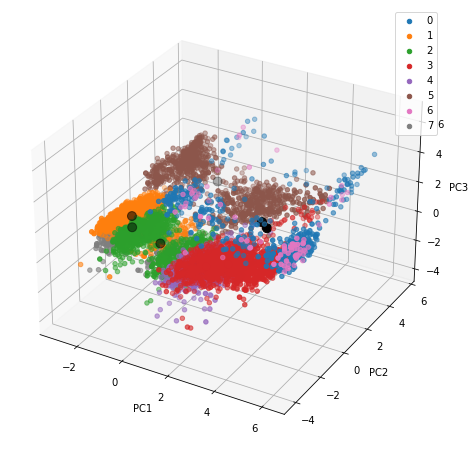

In [249]:
#3D plot
plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')
for i in u_labels:
    ax.scatter3D(new_data[label == i, 0], new_data[label ==
                 i, 1], new_data[label == i, 2], label=i)
ax.scatter3D(centroids[:, 0], centroids[:, 1],
             centroids[:, 2], s=80, color='k')
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.legend()
plt.show()


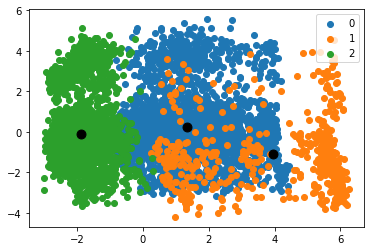

In [250]:
#Initialize the class object
kmeans = KMeans(n_clusters= 3)
 
#predict the labels of clusters.
label = kmeans.fit_predict(new_data)
 
#Getting unique labels
centroids = kmeans.cluster_centers_
u_labels = np.unique(label)
 
#plotting the results:
for i in u_labels:
    plt.scatter(new_data[label == i , 0] , new_data[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

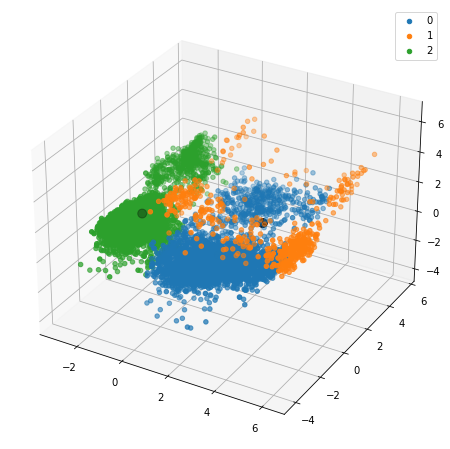

In [251]:
#3D plot
plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')
for i in u_labels:
    ax.scatter3D(new_data[label == i, 0], new_data[label ==
                 i, 1], new_data[label == i, 2], label=i)
ax.scatter3D(centroids[:, 0], centroids[:, 1],
             centroids[:, 2], s=80, color='k')
plt.legend()
plt.show()


In [252]:
dist_df = []
for num_clusters in range(1,11):
    km = KMeans(n_clusters=num_clusters)
    km.fit(new_data)
    dist_df.append([num_clusters, km.inertia_])
dist_df = pd.DataFrame(dist_df, columns=['number_of_clusters', 'distance'])

In [253]:
dist_df


,number_of_clusters,distance
0,1,241103.312784
1,2,215957.988769
2,3,200452.951549
3,4,187825.298762
4,5,180691.912660
5,6,173410.008966
6,7,167306.770834
7,8,162551.254566
8,9,155875.485569
9,10,152951.836986


Text(0.5, 1.0, 'K-Means Elbow Method')

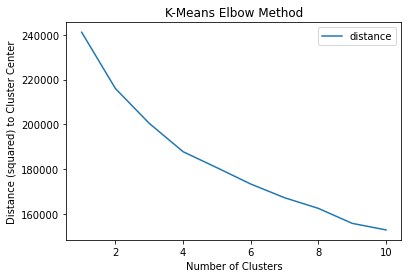

In [254]:
dist_df.set_index("number_of_clusters").plot()
plt.xlabel("Number of Clusters")
plt.ylabel("Distance (squared) to Cluster Center")
plt.title("K-Means Elbow Method")

## ทำการ Train Model K_mean และเลือก select feature โดยผู้จัดทำ

ทำการ Plot graph ของ Feature ใน dataset ด้วย Heatmap correlation plot โดยผู้จัดทำจะทำการแบ่งพิจารณา Numerical กับ Categorical 

In [255]:
Cat_df = df.select_dtypes(include=['object'])
Num_df = df.select_dtypes(exclude=['object'])
Output = df['Attrition_Flag']
Output = Output.replace(['Existing Customer','Attrited Customer'],[0,1])

Cat_df = Cat_df.drop(['Attrition_Flag'], axis=1)
Cat_df = pd.concat([Cat_df,Output],axis=1)
Cat_df = pd.get_dummies(Cat_df)

Num_df = pd.concat([Num_df,Output],axis=1)

1.พิจารณา Categorical Data

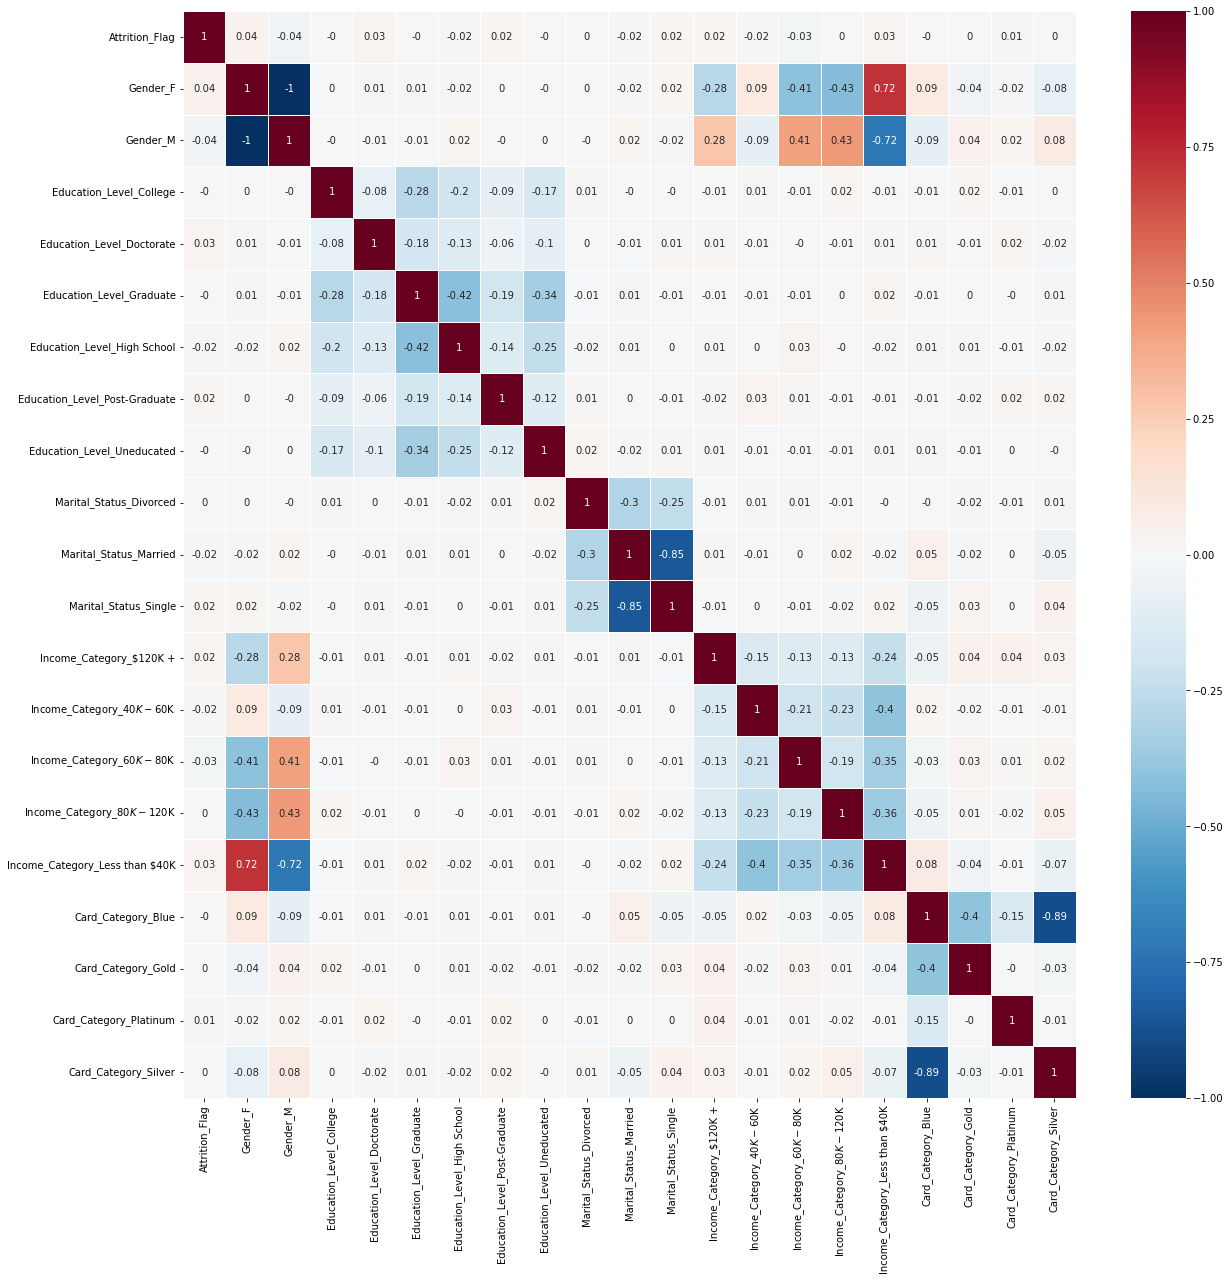

In [256]:
plt.figure(figsize = (20,20))
sns.heatmap(round(Cat_df.corr(),2),annot=True,cmap='RdBu_r', linewidths=.5)
plt.show()

เราทำการเลือกตัดข้อมูลที่เป็นประเภท Categorical ทิ้งออกไปทั้งหมดเนื่องจากข้อมูลของทุก Feature ไม่มีความสัมพันธ์กับตัว Output เลย

2.พิจารณา Numerical Data

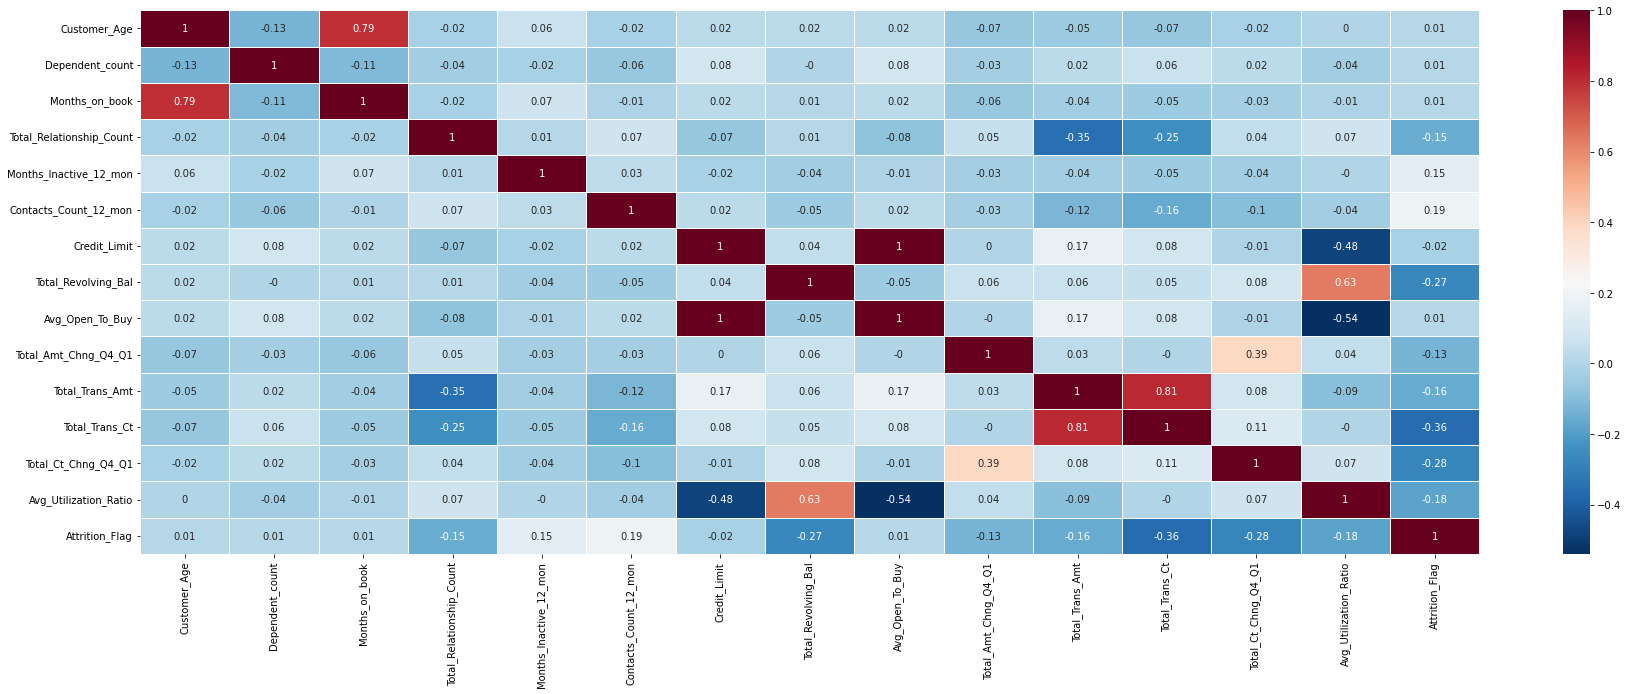

In [257]:
plt.figure(figsize=(30, 10))
sns.heatmap(round(Num_df.corr(), 2), annot=True, cmap='RdBu_r', linewidths=.5)
plt.show()


เลือก Feature ที่จะนำไปพิจารณาโดยเราจะเลือกข้อมูลที่ Feature มีความสัมพันธ์กับ Feature มากที่สุด และข้อมูล Feature มีความสัมพันธ์กับ Output จากการเลือกก่อนหน้านี้

พิจารณา Feature กับ Feature ที่มีความสัมพันธ์กันมากโดย scale ไว้ที่ (corr >= +-0.25)

1.เลือกพิจารณา Months_on_book และ Customer_Age โดยมีความสัมพันธ์ระหว่าง Feature กับ Feature อยู่ที่ 0.79

2.เลือกพิจารณา Credit_Limit และ Avg_Open_To_Buy โดยมีความสัมพันธ์ระหว่าง Feature กับ Feature อยู่ที่ 1

3.เลือกพิจารณา Total_Trans_Ct และ Total_Trans_Amt โดยมีความสัมพันธ์ระหว่าง Feature กับ Feature อยู่ที่ 0.81

4.เลือกพิจารณา Avg_Utilization_Ratio และ Total_Revolving_Bal โดยมีความสัมพันธ์ระหว่าง Feature กับ Feature อยู่ที่ 0.63

5.เลือกพิจารณา Avg_Utilization_Ratio และ Avg_Open_To_Buy โดยมีความสัมพันธ์ระหว่าง Feature กับ Feature อยู่ที่ -0.54

6.เลือกพิจารณา Avg_Utilization_Ratio และ Credit_Limit โดยมีความสัมพันธ์ระหว่าง Feature กับ Feature อยู่ที่ -0.48

7.เลือกพิจารณา Total_Ct_Chng_Q4_Q1 และ Total_Amt_Chng_Q4_Q1 โดยมีความสัมพันธ์ระหว่าง Feature กับ Feature อยู่ที่ 0.39

8.เลือกพิจารณา Total_Trans_Amt และ Total_Relationship_Count โดยมีความสัมพันธ์ระหว่าง Feature กับ Feature อยู่ที่ -0.35

9.เลือกพิจารณา Total_Trans_Ct และ Total_Relationship_Count โดยมีความสัมพันธ์ระหว่าง Feature กับ Feature อยู่ที่ -0.25

พิจารณา Feature กับ Output ที่มีความสัมพันธ์กันน้อยเพื่อเลือกตัด Feature ที่ไม่สำคัญออก

1.เราทำการตัด Months_on_book และ Customer_Age เพราะเป็น Feature ที่มีความสัมพันธ์น้อยกับตัว Output 

2.เราทำการตัด Credit_Limit และ Avg_Open_To_Buy เพราะเป็น Feature ที่มีความสัมพันธ์น้อยกับตัว Output 

3.เราทำการตัด Total_Trans_Amt และที่จะเก็บ Total_Trans_Ct ไว้เพราะเป็น Feature ที่มีความสัมพันธ์กับตัว Output มาก

4.เราทำการตัด Avg_Utilization_Ratio และที่จะเก็บ Total_Revolving_Bal ไว้เพราะเป็น Feature ที่มีความสัมพันธ์กับตัว Output มาก และมองว่าค่าความสัมพันธ์ ของ Total_Revolving_Bal และ Avg_Utilization_Ratio สูงแสดงว่าข้อมูลมีความใกล้เคียงกันจึงเลือกตัดออกไป 1 ตัว

5.เราทำการตัด 2 Feature : Avg_Utilization_Ratio และ Avg_Open_To_Buy ออกไปก่อนหน้านี้แล้วข้อนี้จึงไม่ต้องพิจารณา

6.เราทำการตัด 2 Feature : Avg_Utilization_Ratio และ Credit_Limit ออกไปก่อนหน้านี้แล้วข้อนี้จึงไม่ต้องพิจารณา

7.เราทำการตัด Total_Ct_Chng_Q4_Q1 และที่จะเก็บ Total_Amt_Chng_Q4_Q1 ไว้เพราะเป็น Feature ที่มีความสัมพันธ์กับตัว Output มาก

8.เราทำการเลือกเก็บ Total_Relationship_Count เพราะ Total_Trans_Ct ทำการตัดออกไปแล้ว

9.เราทำการเลือกเก็บทั้ง 2 Feature : Total_Trans_Ct และ Total_Relationship_Count เพราะมีความสัมพันธ์กันเองค่อนข้างน้อยแต่มีความสัมพันธ์กับ Output มาก

10.จาก corr ของ Heatmap correlation plot ทำให้เราได้ 2 Feature ที่มีความสัมพันธ์กับ Output คือ Contacts_Count_12_mon และ Months_Inactive_12_mon

สรุป Feature ที่เก็บไว้

Feature : Total_Trans_Ct,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Relationship_Count,Contacts_Count_12_mon,Months_Inactive_12_mon

In [258]:
print(Num_df.columns)

Index(['Customer_Age', 'Dependent_count', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Attrition_Flag'],
      dtype='object')


In [259]:
DFUse = Num_df[['Total_Trans_Ct','Total_Revolving_Bal','Total_Amt_Chng_Q4_Q1','Total_Relationship_Count','Contacts_Count_12_mon','Months_Inactive_12_mon','Attrition_Flag']]
Output = 'Attrition_Flag'

ทำการ Plot graph พิจารณา Distribution ของข้อมูลทั้งหมดด้วยของ Feature ใน dataset ด้วย Histrogram plot

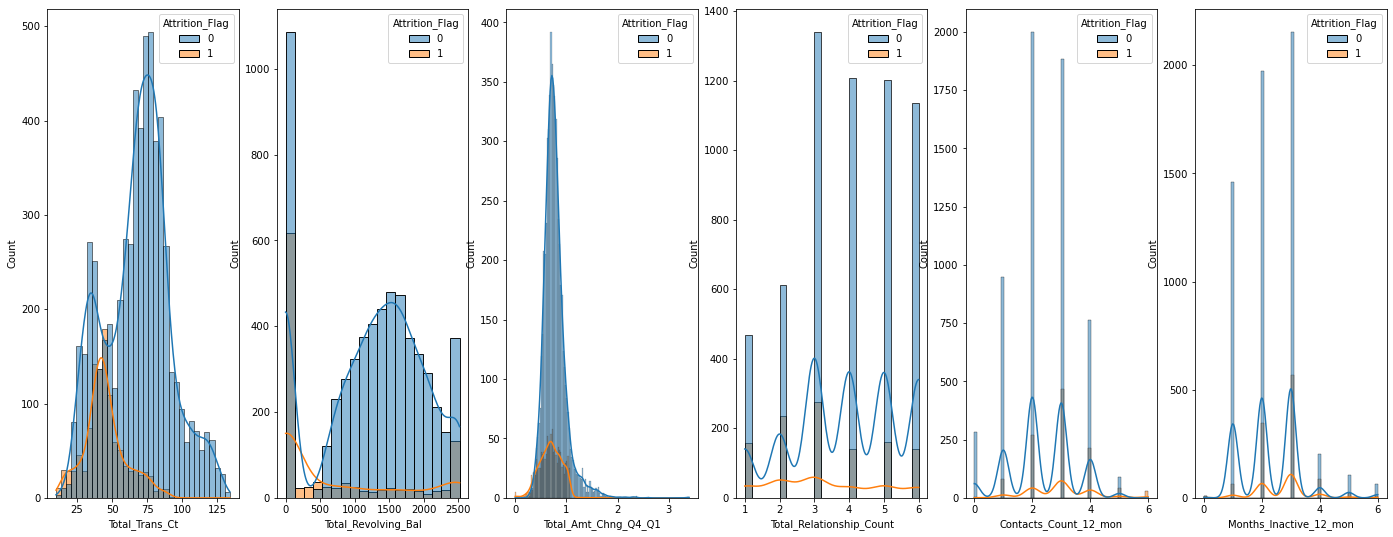

In [260]:
fig,ax = plt.subplots(1,6,figsize=(24,9))
col = DFUse.columns
for i in range(0,6): 
    # print(col[i])
    # print(ax[floor(i/4)][i%4])
    # sns.histplot(data = DFUse, x = col[i], kde = True, hue = Output ,ax=ax[floor(i/4)][i%4])
    # sns.histplot(x = DFUse[Columns[i]], kde = True, hue = Num_df['Attrition_Flag'] ,ax=ax[i])     # could run
    sns.histplot(data = DFUse, x = col[i], kde = True, hue = Output ,ax=ax[i])
plt.show()

ทำการ Plot graph พิจารณา Outlier ของข้อมูลทั้งหมดด้วยของ Feature ใน dataset ด้วย Box plot

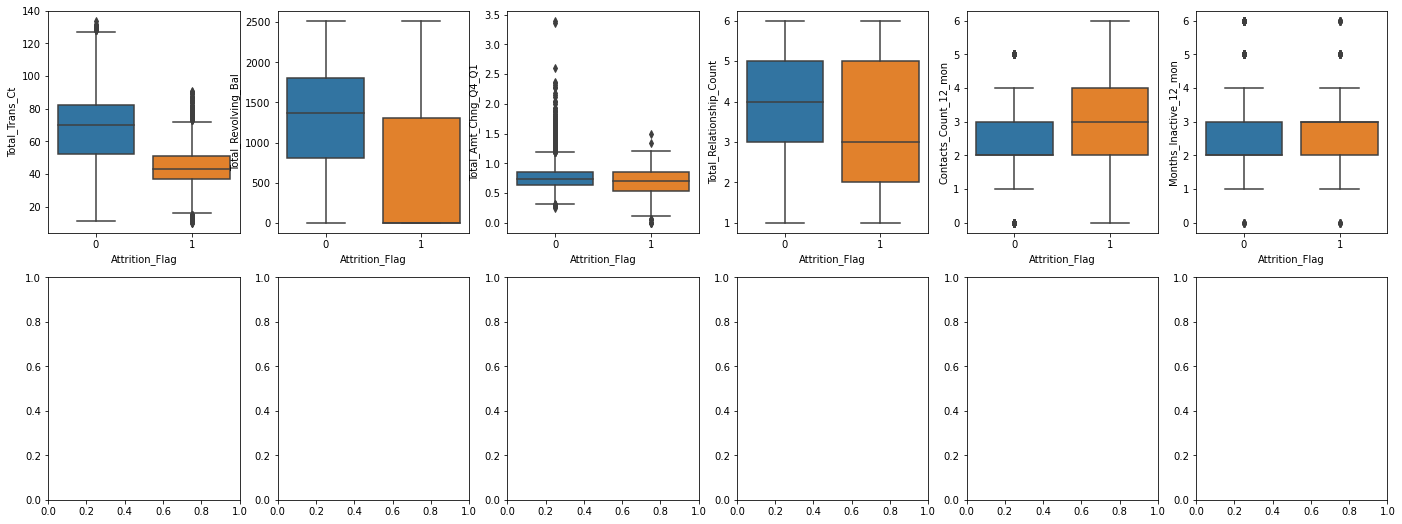

In [261]:
fig,ax = plt.subplots(2,6,figsize=(24,9))
col = DFUse.columns
for j in range(0,6):
    # sns.boxplot(data = DFUse,y = col[j], x = col[-1],ax=ax[i])
    # sns.boxplot(data = numDF_target,y = col[j],ax=ax[i][j%4])
    # sns.boxplot(x = DFUse[Columns[j]] ,ax=ax[j])
    sns.boxplot(data = DFUse ,y = col[j],x = col[-1] ,ax=ax[0][j])
plt.show()

ทำการ Plot graph พิจารณาข้อมูลที่เหลือของ Feature ใน dataset

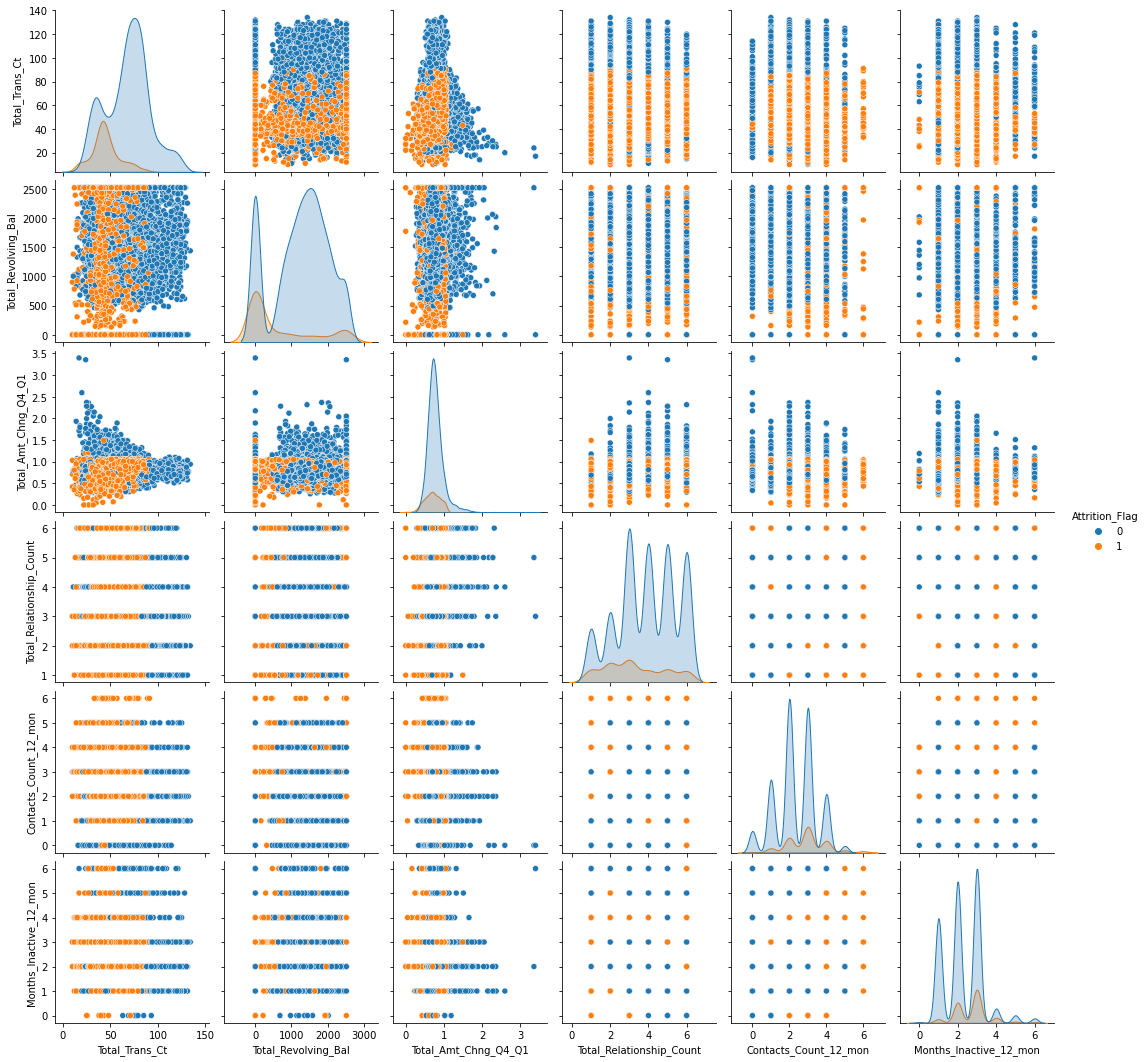

In [262]:
sns.pairplot(DFUse,hue= 'Attrition_Flag')

In [263]:
Num_K = [i+2 for i in range(9)]
silhouette_coef = []

for k in Num_K:
  kmeans = KMeans(n_clusters=k, random_state=1,)
  model = kmeans.fit(DFUse)
  labels = model.labels_
  silhouette_coef.append(metrics.silhouette_score(DFUse, labels, metric='euclidean'))
silhouette_coef

[0.6326315568284938,
 0.6321881010080911,
 0.6453493493181224,
 0.639848642265427,
 0.6379960273909898,
 0.6288455724792335,
 0.6263988642658831,
 0.6210345141918036,
 0.6124476442274721]

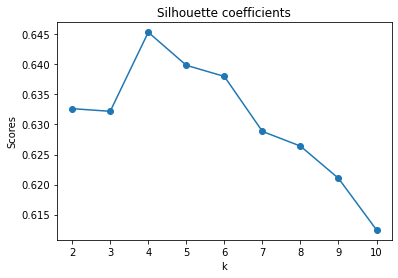

In [264]:
plt.scatter(Num_K, silhouette_coef)
plt.plot(Num_K, silhouette_coef)
plt.title('Silhouette coefficients')
plt.ylabel('Scores')
plt.xlabel('k')
plt.show()

In [265]:
Num_K = [i+1 for i in range(10)]
WCSS = []

for k in Num_K:
  kmeans = KMeans(n_clusters=k, random_state=1,)
  model = kmeans.fit(DFUse)
  WCSS.append(model.inertia_)
WCSS


[4675832405.360599,
 1245132760.9749157,
 470074179.81522226,
 219040855.23574674,
 127575754.8872906,
 82833500.571627,
 59703469.541843995,
 45057597.09793756,
 35663425.24302352,
 29563841.12313358]

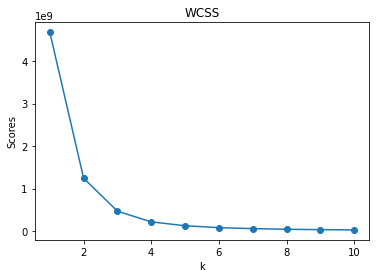

In [266]:
plt.scatter(Num_K,WCSS )
plt.plot(Num_K,WCSS )
plt.title('WCSS')
plt.ylabel('Scores')
plt.xlabel('k')
plt.show()

In [267]:
# print(new_data)
# print("*"*100)
# print(principal_x)
# print("*"*100)
print(DFUse)
print("*"*100)
DFUse_numpy = DFUse.to_numpy()
print(DFUse_numpy)

       Total_Trans_Ct  Total_Revolving_Bal  Total_Amt_Chng_Q4_Q1  \
0                  42                  777                 1.335   
1                  33                  864                 1.541   
2                  20                    0                 2.594   
4                  28                    0                 2.175   
5                  24                 1247                 1.376   
...               ...                  ...                   ...   
10120             114                 2109                 0.660   
10121             120                  606                 0.570   
10122             117                 1851                 0.703   
10124              60                    0                 0.819   
10126              61                 1961                 0.703   

       Total_Relationship_Count  Contacts_Count_12_mon  \
0                             5                      3   
1                             6                      2   
2        

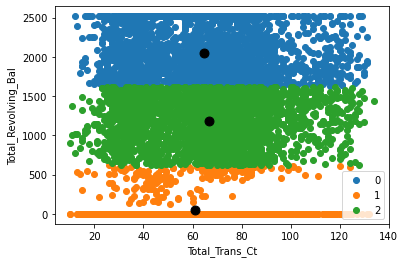

In [268]:
#Initialize the class object
kmeans = KMeans(n_clusters= 3)
 
#predict the labels of clusters.
label = kmeans.fit_predict(DFUse_numpy)
 
#Getting unique labels
centroids = kmeans.cluster_centers_
u_labels = np.unique(label)
 
#plotting the results:
for i in u_labels:
    plt.scatter(DFUse_numpy[label == i , 0] , DFUse_numpy[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.xlabel("Total_Trans_Ct")
plt.ylabel("Total_Revolving_Bal")
plt.legend()
plt.show()

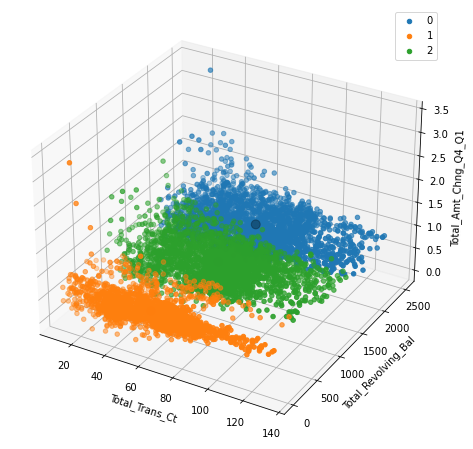

In [269]:
#3D plot
plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')
for i in u_labels:
    ax.scatter3D(DFUse_numpy[label == i, 0], DFUse_numpy[label ==
                 i, 1], DFUse_numpy[label == i, 2], label=i)
ax.scatter3D(centroids[:, 0], centroids[:, 1],
             centroids[:, 2], s=80, color='k')
ax.set_xlabel("Total_Trans_Ct")
ax.set_ylabel("Total_Revolving_Bal")
ax.set_zlabel("Total_Amt_Chng_Q4_Q1")
plt.legend()
plt.show()


## Summary

จากทำการตั้งสมมุติฐานและการทดลองทำตามสมมุติฐานพบว่า 

1.การใช้ตัว Feature Selection ด้วยตัว PCA แล้วนำเข้าไปเรียนรู้ด้วยตัวโมเดล K_mean ทำให้ได้ข้อสรุปไม่ตรงตามสมมุติฐานที่ตั้งเอาไว้คือได้ผลลัพธ์ของ Cluster ที่อธิบายข้อมูลได้ดีที่สุด เพราะจากการทดสอบประสิทธิภาพด้วยตัว Silhouette coefficients ผลลัพธ์ที่ได้คือ [0.10979256340805783,0.12120829803696294] จากผลลัพธ์สามารถอธิบายได้ว่าค่า S มีค่าเข้าใกล้ 0 ทำให้การแบ่ง Cluster ได้ไม่ดีและสังเกตจากกราฟที่แสดงออกมาดังรูป 

<center><img src="Picture_Output_PCA_Kmean_3_cluster.png" width="600"/></center>
รูปภาพ output ของการ train kmean ด้วย pca

จากรูปตัวของ Cluster 1 จะมีข้อมูลที่จะเข้าไปปะปนกับตัว Cluster 0 มากเกินไปและตัว Cluster 2 จะมีข้อมูลบางตัวเข้าไปปะปนกับ Cluster 0 ทำให้ Cluster ที่แบ่งออกมายังจำแนกประเภทได้ไม่ดีเท่าที่ตั้งสมมุติฐานเอาไว้

2.การพิจารณาการทำ Feature Selection ที่เทียบกับ target ตามเป้าหมายของ Dataset credit_card_chun โดยผ่านการ plot ด้วยกราฟ Heatmap Correlation plot, Histrogram Distribution plot, Box Outlier plot และ Seaborn Pair plot แล้วนำเข้าไปเรียนรู้ด้วยตัวโมเดล K_mean ทำให้ได้ข้อสรุปตรงตามสมมุติฐานบางส่วนที่ตั้งเอาไว้คือได้ผลลัพธ์ของ Cluster ที่อธิบายข้อมูลได้ดีแต่อาจจะไม่ใช่ผลลัพธ์การแบ่งข้อมูล Cluster ที่ดีที่สุดเพราะจากการทดสอบประสิทธิภาพด้วยตัว Silhouette coefficients ผลลัพธ์ที่ได้คือ [0.6326315568284938,0.6124476442274721] จากผลลัพธ์สามารถอธิบายได้ว่าค่า S มีค่ามากกว่า 0.5 ขึ้นมาและเข้าใกล้ 1 ทำให้การแบ่ง Cluster พอได้และสังเกตจากกราฟที่แสดงออกมาดังรูป 

<center><img src="Picture_Output_BySelf_Kmean_3_cluster.png" width="600"/></center>
รูปภาพ output ของการ train kmean ด้วย Heatmap Correlation plot, Histrogram Distribution plot, Box Outlier plot และ Seaborn Pair plot

จากรูปมีการแบ่ง Cluster ที่ชัดเจนทั้ง 3 Cluster โดยข้อมูลที่ทำการ Cluster ออกมาไม่มีการปนกันของข้อมูลที่เกิดขึ้น ทำให้เราสามารถจำแนกข้อมูลที่อยู่ภายในในการพิจารณาต่อไป 

ข้อมูลที่นำมา Plot graph ประกอบไปด้วยแกน x : Total_Revolving_Bal กับแกน y : Total_Trans_Ct ทำให้ข้อมูลที่ถูก cluster ออกมาคือ ในช่วง 12 เดือนที่ผ่านการทำธุรกรรมมา มีการใช้วงเงินที่เกินบัตรเคดิตไปเป็นจำนวนเท่าไรตามกลุ่ม

3.จากการทำตามทั้ง 2 สมมุติฐานทำให้เราทราบการแบ่ง Cluster ทั้ง 2 การ Preprocessing Data จากผลสรุปคือ ในการทำการบ้านครั้งนี้การที่ Preprocessing ด้วยตัวเองจากการ Feature Selection ด้วย Heatmap Correlation plot, Histrogram Distribution plot, Box Outlier plot และ Seaborn Pair plot มีประสิทธิภาพมากกว่าการ Feature Selection ด้วย PCA

ผู้จัดทำ 
1.นายก้องภพ ทองดี 63340500003
2.นายพันธุ์ธัช ลิขิตบัณฑูร  63340500040